# Lab 4

Excercise 5

# Tutorial Using MNIST in Keras

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
#from keras.preprocessing.image import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np

#load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#preprocess data
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#compile CNN network for MNIST classification 
inputs = Input(shape=(28,28,1))
net = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(inputs)
net = Conv2D(64, kernel_size=(3, 3),
                 activation='relu')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)
net = Flatten()(net)
net = Dense(128, activation='relu')(net)
net = Dropout(0.5)(net)
outputs = Dense(10, activation='softmax')(net)

mnist_model = Model(inputs=inputs, outputs=outputs, name='classification_model')
mnist_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[categorical_accuracy])

#train MNIST classifer
earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=0, mode='auto',
                          baseline=None, restore_best_weights=True)

mnist_model.fit(x_train, y_train, batch_size=128, epochs=50, verbose='auto', validation_data=(x_test, y_test),
               callbacks=[earlyStop])

print(mnist_model.evaluate(x_train, y_train))
print(mnist_model.evaluate(x_test, y_test))

Epoch 1/50
469/469 [==============================] - 32s 66ms/step - loss: 0.2429 - categorical_accuracy: 0.9256 - val_loss: 0.0522 - val_categorical_accuracy: 0.9842
Epoch 2/50
469/469 [==============================] - 30s 64ms/step - loss: 0.0848 - categorical_accuracy: 0.9745 - val_loss: 0.0383 - val_categorical_accuracy: 0.9861
Epoch 3/50
469/469 [==============================] - 30s 65ms/step - loss: 0.0642 - categorical_accuracy: 0.9808 - val_loss: 0.0337 - val_categorical_accuracy: 0.9886
Epoch 4/50
469/469 [==============================] - 31s 65ms/step - loss: 0.0501 - categorical_accuracy: 0.9841 - val_loss: 0.0301 - val_categorical_accuracy: 0.9910
Epoch 5/50
469/469 [==============================] - 30s 63ms/step - loss: 0.0426 - categorical_accuracy: 0.9871 - val_loss: 0.0320 - val_categorical_accuracy: 0.9898
Epoch 6/50
469/469 [==============================] - 29s 62ms/step - loss: 0.0381 - categorical_accuracy: 0.9878 - val_loss: 0.0351 - val_categorical_accuracy:

## Image Selection

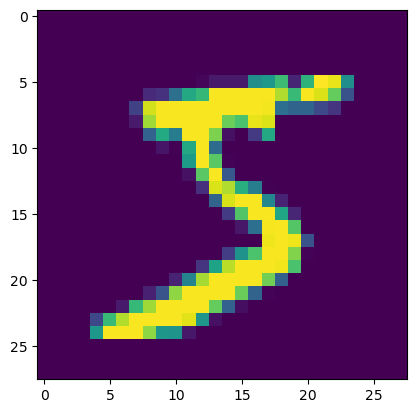

1/1 [==============================] - 0s 16ms/step
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


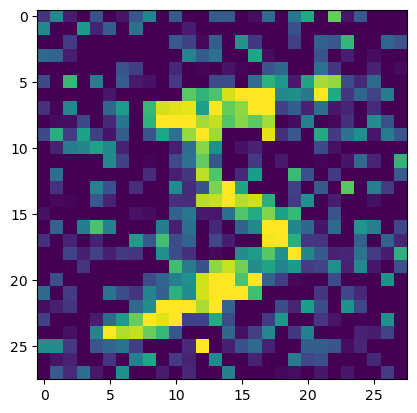

1/1 [==============================] - 0s 21ms/step
[0.    0.    0.    0.061 0.    0.939 0.    0.    0.    0.   ]


In [8]:
#select image to create an adversarial example from
img = x_train[0:1]
plt.imshow(img.reshape((28,28)),vmin=0., vmax=1.)
plt.show()
#varify accurate classificaiton
prediction = mnist_model.predict(img)[0]
print(prediction.round(decimals=3))

#applying random noise does not fool the classifier
quantized_noise = np.round(np.random.normal(loc=0.0, scale=0.3, size=img.shape) * 255.) / 255.
noisy_img = np.clip(img + quantized_noise, 0., 1.)
plt.imshow(noisy_img.reshape((28,28)),vmin=0., vmax=1.)
plt.show()
noisy_prediction = mnist_model.predict(noisy_img)[0]
print(noisy_prediction.round(decimals=3))

## Adversarial Sample Generation

In [27]:
y_train_max = np.argmax(y_train, axis=1)

In [28]:
y_train_max

array([5, 0, 4, ..., 5, 6, 8], dtype=int64)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


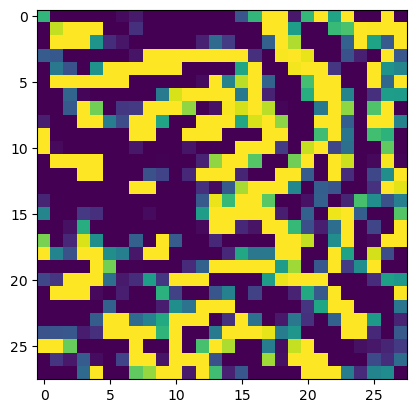

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

---- Next ----
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


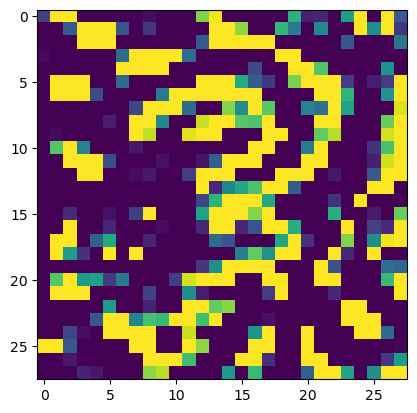

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

---- Next ----
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


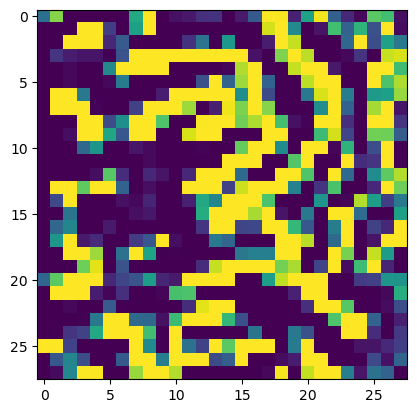

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

---- Next ----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


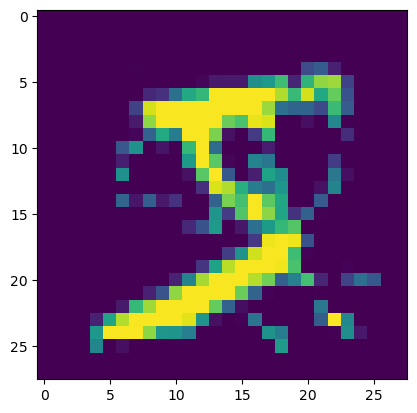

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

---- Next ----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


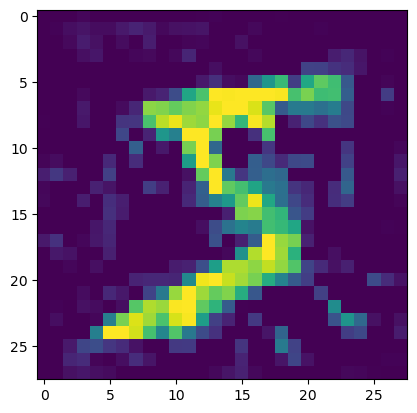

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

---- Next ----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


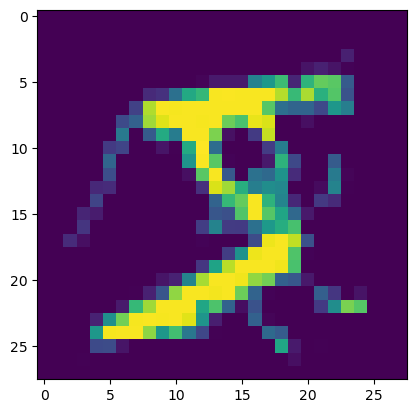

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

---- Next ----


In [32]:
#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})


#function for generating an adversarial example given a base image, adversarial class target, classifier, and regularization type
def generate_adversary(img,target,model,regularization,loss_function):
    
    #input for base image
    image = Input(shape=(28,28,1),name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='one')
    
    #layer for learning adversarial noise to apply to image
    noise = Dense(28*28,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape((28,28,1),name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    net = Activation('clip',name='clip_values')(net)
    
    #feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False
    
    adversarial_model.compile(optimizer='adam', loss=loss_function, metrics=[categorical_accuracy])
        
    #target adversarial classification
    target_vector = np.zeros(10)
    target_vector[target] = 1.

    print(target_vector)
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('./adversarial_weights.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                 mode='auto', save_freq=1)
    #train adversarial image
    adversarial_model.fit(x={'image':img,'one':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=10000,verbose=0,
                         callbacks=[checkpoint])
    #restore best weights
    adversarial_model.load_weights('./adversarial_weights.h5')
    
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((28,28)) * 255.) / 255.
    
    #add trained weights to original image and clip values to produce adversarial image
    adversarial_img = np.clip(img.reshape((28,28)) + quantized_weights, 0., 1.)
    
    #display adversarial image
    plt.imshow(adversarial_img,vmin=0., vmax=1.)
    plt.show()
    #classify adversarial image
    adversarial_prediction = mnist_model.predict(adversarial_img.reshape((1,28,28,1)), verbose=0)
    print(adversarial_prediction.round(decimals=3))
    print()
    print('---- Next ----')
    
    return adversarial_img

adv_img = []
adv_img.append(generate_adversary(img,5,mnist_model,l1(0.01),'negative_categorical_crossentropy'))
adv_img.append(generate_adversary(img,5,mnist_model,l2(0.01),'negative_categorical_crossentropy'))
adv_img.append(generate_adversary(img,5,mnist_model,l1_l2(l1=0.01,l2=0.01),'negative_categorical_crossentropy'))

adv_img.append(generate_adversary(img,9,mnist_model,l1(0.01),'categorical_crossentropy'))
adv_img.append(generate_adversary(img,9,mnist_model,l2(0.01),'categorical_crossentropy'))
adv_img.append(generate_adversary(img,9,mnist_model,l1_l2(l1=0.01,l2=0.01),'categorical_crossentropy'))